<a href="https://colab.research.google.com/github/Swarna1804/GenerativeAI/blob/main/GAN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt=Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

In [ ]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  X = X / 255.0
  return X

In [ ]:
def generate_real_samples(datset,n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  return X, y

In [ ]:
def generate_latent_space(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_space(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = zeros((n_samples, 1))
  return X,y

In [ ]:
def save_plot(examples, epoch, n=10):
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

In [ ]:
def summarize_performance(epoch,g_model, d_model, dataset, latent_dim, n_samples=100):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      d_loss, _ = d_model.train_on_batch(X, y)
      X_gan = generate_latent_space(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
  if (i+1) % 10 == 0:
    summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim=100
d_model=define_discriminator()
g_model=define_generator(latent_dim)
gan_model=define_gan(g_model, d_model)
dataset=load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


>1, 1/234, d=0.687, g=0.691
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>1, 2/234, d=0.686, g=0.686
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
>1, 3/234, d=0.686, g=0.687
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>1, 4/234, d=0.687, g=0.688
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 5/234, d=0.687, g=0.687
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 6/234, d=0.686, g=0.687
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 7/234, d=0.687, g=0.687
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
>1, 8/234, d=0.688, g=0.686
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 9/234, d=0.688, g=0.685
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 10/234, d=0.689, g=0.684
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 11/234, d=0.690, g=0.682
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 12/234, d=0.691, g=0.680
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 13/234, d=0.692, g=0.678
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
>1, 14/234, d=0.693, g=0.675
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>1, 15/234, d=0.694, g=0.673
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>1, 

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.56MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/10], Loss C: 291.15972900390625, Loss G: 270.41864013671875
Epoch [2/10], Loss C: -5530.1962890625, Loss G: -2018.708740234375
Epoch [3/10], Loss C: -295.7403564453125, Loss G: -600.6686401367188
Epoch [4/10], Loss C: -2322.212890625, Loss G: 31820.75390625
Epoch [5/10], Loss C: 2313.31884765625, Loss G: -341.1521911621094
Epoch [6/10], Loss C: -16100.984375, Loss G: 987.8457641601562
Epoch [7/10], Loss C: 5454.330078125, Loss G: -9226.861328125
Epoch [8/10], Loss C: -42707.1015625, Loss G: 88169.6640625
Epoch [9/10], Loss C: -3592.0517578125, Loss G: 21830.03125
Epoch [10/10], Loss C: -16282.41796875, Loss G: 4662.0537109375


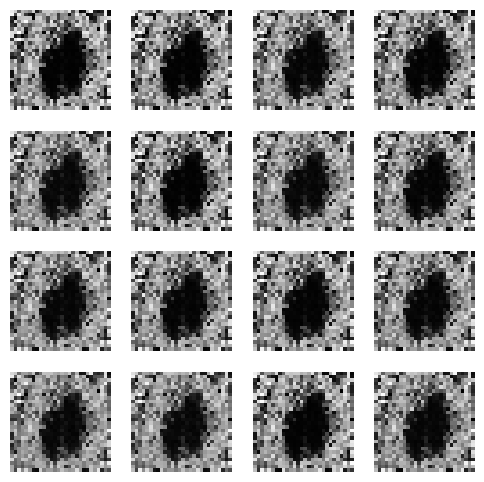

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Hyperparameters (Modified)
batch_size = 128  # Changed from original
learning_rate = 0.0001  # Adjusted for stability
latent_dim = 128  # Increased from original 100

# Load Fashion-MNIST dataset
dataset = datasets.FashionMNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator class
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Critic class
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Initialize models
generator = Generator(latent_dim)
critic = Critic()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_C = optim.Adam(critic.parameters(), lr=learning_rate)

# Training Loop
epochs = 10
for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.shape[0]
        real_images = real_images.view(batch_size, -1)
        z = torch.randn(batch_size, latent_dim)
        fake_images = generator(z)

        # Train Critic
        critic_real = critic(real_images)
        critic_fake = critic(fake_images.detach())
        loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))
        optimizer_C.zero_grad()
        loss_C.backward()
        optimizer_C.step()

        # Train Generator
        if batch_idx % 5 == 0:  # Train Generator less frequently
            critic_fake = critic(fake_images)
            loss_G = -torch.mean(critic_fake)
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss C: {loss_C.item()}, Loss G: {loss_G.item()}")

# Generate Inference
import matplotlib.pyplot as plt

def generate_and_display():
    with torch.no_grad():
        z = torch.randn(16, latent_dim)
        samples = generator(z)
        samples = samples.view(16, 28, 28).cpu()

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(samples[i], cmap='gray')
            ax.axis('off')
        plt.show()

generate_and_display()
